In [1]:
import torchvision 
import torch.nn as nn 
import torch 
import torch.nn.functional as F 
from torchvision import transforms,models,datasets 
import matplotlib.pyplot as plt 
from PIL import Image 
import numpy as np 
from torch import optim 

from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler, WeightedRandomSampler
import pandas as pd
import seaborn as sns

In [2]:
np.random.seed(0)
torch.manual_seed(0)

In [3]:
data_dir = "D:/DatasetsCD/binary_classification_covid_dataset"

transform = transforms.Compose([transforms.Resize(100), 
    transforms.CenterCrop(224), 
    transforms.RandomHorizontalFlip(),                            
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])]) 

dataset = torchvision.datasets.ImageFolder(data_dir, transform= transform)
#train_loader = torch.utils.data.DataLoader(dataset, batch_size=15 ,shuffle=True) 

In [4]:
idx2class = {v: k for k, v in dataset.class_to_idx.items()}

def get_class_distribution(dataset_obj):
    
    count_dict = {k:0 for k,v in dataset_obj.class_to_idx.items()}
    for element in dataset_obj:
        y_lbl = element[1]
        y_lbl = idx2class[y_lbl]
        count_dict[y_lbl] += 1
    
    return count_dict

print("Distribution of classes: \n", get_class_distribution(dataset))

Distribution of classes: 
 {'COVID': 1200, 'NORMAL': 1341}


In [3]:
## spliting dataset 80 % training,20 % VALIDATION 
train_dataset, val_dataset = random_split(dataset,(2000,541))

In [4]:
training_loader = DataLoader(dataset=train_dataset, shuffle=True, batch_size=15)
val_loader = DataLoader(dataset=val_dataset, shuffle=False, batch_size=1)

print("Length of the train_loader:", len(training_loader))
print("Length of the val_loader:", len(val_loader))

Length of the train_loader: 134
Length of the val_loader: 541


In [4]:

device = torch.device("cuda:0")
if torch.cuda.is_available():
    device = torch.device("cuda:0")  #
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


In [6]:
torch.cuda.empty_cache()

In [5]:
"""
From scratch implementation of the famous ResNet models.
The intuition for ResNet is simple and clear, but to code
it didn't feel super clear at first, even when reading Pytorch own
implementation. 
Video explanation: 
Got any questions leave a comment on youtube :)
Programmed by Aladdin Persson <aladdin.persson at hotmail dot com>
*    2020-04-12 Initial coding
"""

import torch
import torch.nn as nn


class block(nn.Module):
    def __init__(
        self, in_channels, intermediate_channels, identity_downsample=None, stride=1
    ):
        super(block, self).__init__()
        self.expansion = 4
        self.conv1 = nn.Conv2d(
            in_channels, intermediate_channels, kernel_size=1, stride=1, padding=0, bias=False
        )
        self.bn1 = nn.BatchNorm2d(intermediate_channels)
        self.conv2 = nn.Conv2d(
            intermediate_channels,
            intermediate_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False
        )
        self.bn2 = nn.BatchNorm2d(intermediate_channels)
        self.conv3 = nn.Conv2d(
            intermediate_channels,
            intermediate_channels * self.expansion,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=False
        )
        self.bn3 = nn.BatchNorm2d(intermediate_channels * self.expansion)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
        self.stride = stride

    def forward(self, x):
        identity = x.clone()

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)
        

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x


class ResNet(nn.Module):
    def __init__(self, block, layers, image_channels, num_classes):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Essentially the entire ResNet architecture are in these 4 lines below
        self.layer1 = self._make_layer(
            block, layers[0], intermediate_channels=64, stride=1
        )
        self.layer2 = self._make_layer(
            block, layers[1], intermediate_channels=128, stride=2
        )
        self.layer3 = self._make_layer(
            block, layers[2], intermediate_channels=256, stride=2
        )
        self.layer4 = self._make_layer(
            block, layers[3], intermediate_channels=512, stride=2
        )

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(512 * 4, 128)
        self.fc2 = nn.Linear(128 , num_classes)
        self.fc3 = nn.Sigmoid()
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

    def _make_layer(self, block, num_residual_blocks, intermediate_channels, stride):
        identity_downsample = None
        layers = []

        # Either if we half the input space for ex, 56x56 -> 28x28 (stride=2), or channels changes
        # we need to adapt the Identity (skip connection) so it will be able to be added
        # to the layer that's ahead
        if stride != 1 or self.in_channels != intermediate_channels * 4:
            identity_downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels,
                    intermediate_channels * 4,
                    kernel_size=1,
                    stride=stride,
                    bias=False
                ),
                nn.BatchNorm2d(intermediate_channels * 4),
            )

        layers.append(
            block(self.in_channels, intermediate_channels, identity_downsample, stride)
        )

        # The expansion size is always 4 for ResNet 50,101,152
        self.in_channels = intermediate_channels * 4

        # For example for first resnet layer: 256 will be mapped to 64 as intermediate layer,
        # then finally back to 256. Hence no identity downsample is needed, since stride = 1,
        # and also same amount of channels.
        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, intermediate_channels))

        return nn.Sequential(*layers)


def ResNet50(img_channel=3, num_classes=1):
    return ResNet(block, [3, 4, 6, 3], img_channel, num_classes)






In [6]:
model = (ResNet50()).to(device)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): block(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (identity_downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    

In [11]:
import torch.optim as optim


criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)



In [12]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(y_pred)
    
    correct_result_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_result_sum/y_test.shape[0]
    acc  = torch.round(acc*100)
    
    return acc
    

In [ ]:
## one neurone output and sigmoid, BCELOO

print("Begin training...")

accuracy_stats = {
    'train': [],
    "val": []
             }
loss_stats = {
    'train': [],
    "val": []
             }
Epochs= 10

for epoch in range(Epochs):
    #training
    
    train_epoch_loss = 0
    train_epoch_acc  = 0
    
    model.train()
    for X_train_batch, y_train_batch in training_loader:
        y_train_batch = y_train_batch.to(torch.float32)
        X_train_batch , y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        
        optimizer.zero_grad()
        
        y_train_pred  = model(X_train_batch)
        
        train_loss = criterion( y_train_pred,y_train_batch.unsqueeze(1))
        train_acc = binary_acc(y_train_pred,y_train_batch.unsqueeze(1))
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        
    #training
    with torch.no_grad():
        model.eval()
        val_epoch_loss = 0
        val_epoch_acc = 0
    
        for X_val_batch, y_val_batch in val_loader:
            y_val_batch = y_val_batch.to(torch.float32)
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)

            y_val_pred = model(X_val_batch)
            #y_val_pred = torch.unsqueeze(y_val_pred, 0)

            val_loss = criterion(y_val_pred, y_val_batch.unsqueeze(1))
            val_acc = binary_acc(y_val_pred, y_val_batch.unsqueeze(1))

            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
        
    loss_stats['train'].append(train_epoch_loss/len(training_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(training_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader)) 
            
    print(f"Epoch: {epoch}| train-loss: {train_epoch_loss/len(training_loader)}| val-loss: {val_epoch_loss/len(val_loader)} | train_accuracy : {train_epoch_acc/len(training_loader)} | val_accuracy : {val_epoch_acc/len(val_loader)} ")
      

Begin training...


In [45]:
model.load_state_dict(torch.load('saved_best_model_resnet_binary.pth'))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): block(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (identity_downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    

In [46]:
#preparing test data 
data_dir = "D:\DatasetsCD\Test_set"


transforms2 = transforms.Compose([transforms.Resize((224,224)),
                                  
                                  transforms.ToTensor(),
                                 transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                       std=[0.229, 0.224, 0.225])
                                                           ])

dataset2 =datasets.ImageFolder(data_dir, transform= transforms2)
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=1 ,shuffle=True) 

In [47]:
print(len(test_loader))
dataset2.class_to_idx

606


{'COVID': 0, 'NORMAL': 1}

In [48]:

y_true =[]
y_predicted = []

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x,batch_y = batch_x.to(device),batch_y.to(device)
        
        y_test_pred = model(batch_x)
        y_pred_tag = torch.round(y_test_pred)
        
       
        y_predicted.append(y_pred_tag.cpu().numpy())
        y_true.append(batch_y.cpu().numpy())
 

In [49]:
y_predicted = np.array(y_predicted)
y_predicted = y_predicted.reshape(606,)

y_true =  np.array(y_true)
y_true = y_true.reshape(606,)


In [50]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_predicted, y_true, target_names=['Covid 0', 'NORMAL 1']))

              precision    recall  f1-score   support

     Covid 0       0.99      0.91      0.95       402
    NORMAL 1       0.84      0.99      0.91       204

    accuracy                           0.93       606
   macro avg       0.92      0.95      0.93       606
weighted avg       0.94      0.93      0.94       606



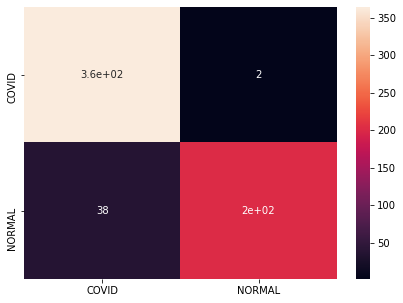

In [51]:
idx2class = {v: k for k, v in dataset2.class_to_idx.items()}
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_true, y_predicted)).rename(columns=idx2class, index=idx2class)
fig, ax = plt.subplots(figsize=(7,5))         
sns.heatmap(confusion_matrix_df, annot=True, ax=ax)

Text(0, 0.5, 'True Positive Rate')

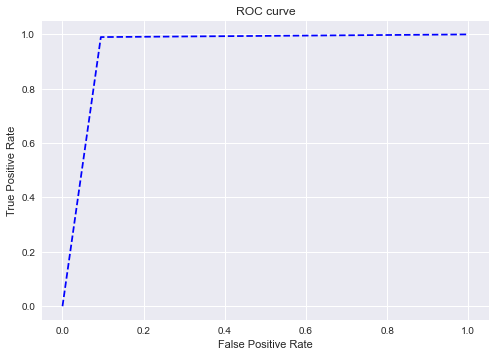

In [52]:
from sklearn.metrics import roc_curve

fpr, tpr, threshold = roc_curve(y_predicted,y_true, pos_label = 1)

import matplotlib.pyplot as plt 
plt.style.use('seaborn')

plt.plot(fpr,tpr,  linestyle = '--', color = 'blue', label = 'ResNet54')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')